In [102]:
import numpy as np 
import matplotlib.pyplot as plt



In [103]:

def random_projections(d,n_projections,Type=0):
    '''
    input: 
    d: int 
    n_projections: int

    output: 
    projections: d*n torch tensor

    '''
#    np.random.seed(0)
    if Type==0:
        Gaussian_vector=np.random.normal(0,1,size=(d,n_projections)) #.astype(np.float64)
        projections=Gaussian_vector/np.sqrt(np.sum(np.square(Gaussian_vector),0))
        projections=projections.T

    elif Type==1:
        r=np.int64(n_projections/d)+1
        projections=np.zeros((d*r,d)) #,dtype=np.float64)
        for i in range(r):
            H=np.random.randn(d,d) #.astype(np.float64)
            Q,R=np.linalg.qr(H)
            projections[i*d:(i+1)*d]=Q
        projections=projections[0:n_projections]
    return projections

def recover_indice(indice_X,indice_Y,L):
    '''
    input:
        indice_X: n*1 float torch tensor, whose entry is integer 0,1,2,....
        indice_Y: m*1 float torch tensor, whose entry is integer 0,1,2,.... 
        L: n*1 list, whose entry could be 0,1,2,... and -1.
        L is the original transportation plan for sorted X,Y 
        L[i]=j denote x_i->y_j and L[i]=-1 denote we destroy x_i. 
        If we ignore -1, it must be in increasing order  
    output:
        mapping_final: the transportation plan for original unsorted X,Y
        
        Eg. X=[2,1,3], indice_X=[1,0,2]
            Y=[3,1,2], indice_Y=[1,2,0]
            L=[0,1,2] which means the mapping 1->1, 2->2, 3->3
        return: 
            L=[2,1,0], which also means the mapping 2->2, 1->1,3->3.
    
    '''
    n=L.shape[0]
    indice_Y_mapped=np.where(L>=0,indice_Y[L],-1)
    mapping=np.vstack((indice_X,indice_Y_mapped))
    mapping_final=mapping[1].take(mapping[0].argsort())
    return mapping_final





In [104]:
#test the projection python code 
# if the code is correct, the printed norm of theta should be 1 
n_projections=10
d=3
projections=random_projections(d,n_projections,Type=1)
for theta in projections:
    print(np.linalg.norm(theta))
    


0.9999999999999999
1.0
0.9999999999999999
1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0
0.9999999999999998


In [105]:
#test the code recover_indice
# if the code is correct, the printed norm of error should be zero. 
n=10
X=np.random.rand(n)
Y=np.random.rand(n)
X_indice,Y_indice=X.argsort(),Y.argsort()
X_s,Y_s=X[X_indice],Y[Y_indice]
L=np.arange(n)
L1=recover_indice(X_indice,Y_indice,L)

diff1=X_s-Y_s
diff2=X-Y[L1]
diff1.sort()
diff2.sort()
error=np.linalg.norm(diff1-diff2)
print(error)

    

0.0


In [388]:
def X_correspondence_sot(X,Y,projections):
    n,d=X.shape
    L_list=[]
    projections2=np.vstack((projections,projections))
    for i,theta in enumerate(projections):
        theta=projections[i]
        X_theta,Y_theta=np.dot(theta,X.T),np.dot(theta,Y.T)
        X_indice,Y_indice=X_theta.argsort(),Y_theta.argsort()
        X_s,Y_s=X_theta[X_indice],Y_theta[Y_indice]
        L=np.arange(n)
        L=recover_indice(X_indice,Y_indice,L)
        Domain,Range=L>=0,L[L>=0]
        
        for epoch in range(d):
            theta0=projections2[i+epoch]
            X_theta0,Y_theta0=np.dot(theta0,X.T),np.dot(theta0,Y.T)
            X+=np.expand_dims(Y_theta0[Range]-X_theta0[Domain],1)*theta0
            X_theta,Y_theta=np.dot(theta,X.T),np.dot(theta,Y.T)
            print(np.linalg.norm(X_theta[Domain]-Y_theta[Range]))
            
            
        plt.scatter(X[:,0],X[:,1])
        plt.scatter(Y[:,0],Y[:,1])
        plt.show()
        
    

    



4.708743832993896e-16
1.0759537581007686e-15


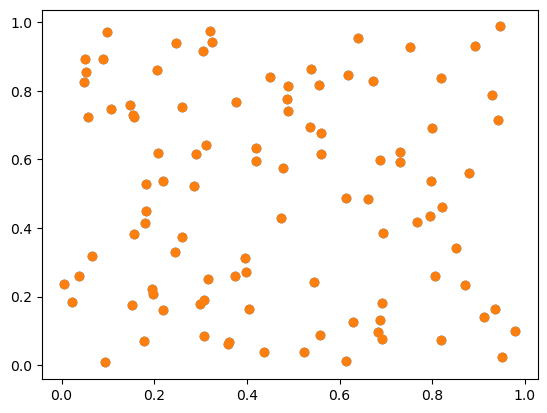

9.621071039760154e-17
2.285362393130493e-16


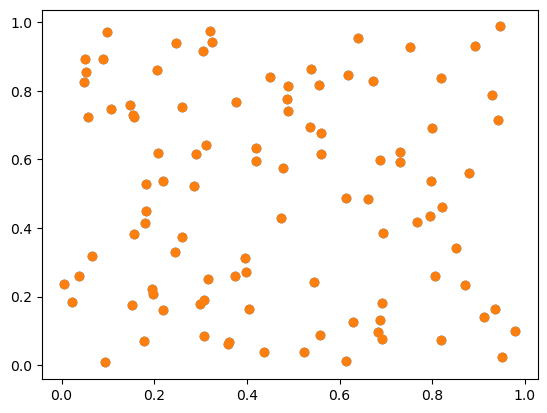

8.673617379884035e-17
1.7629434045807887e-16


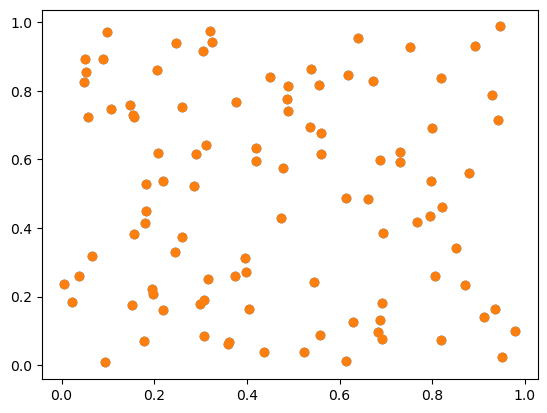

0.0
2.309724214262959e-16


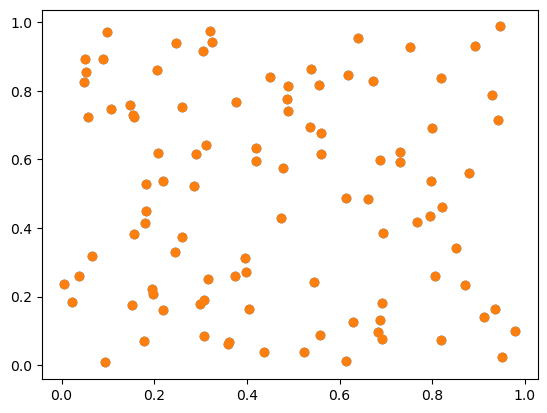

0.0
0.0


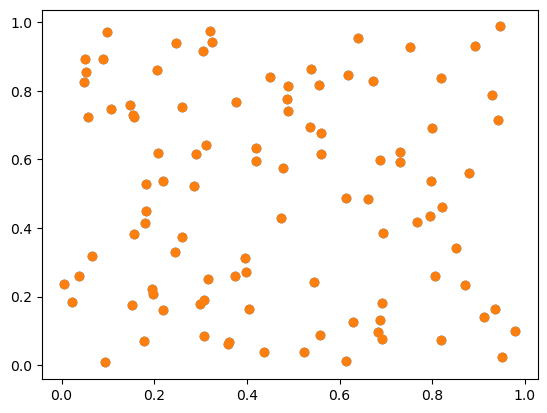

0.0
0.0


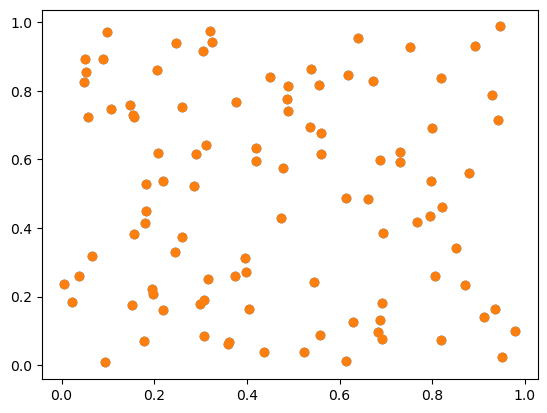

0.0
0.0


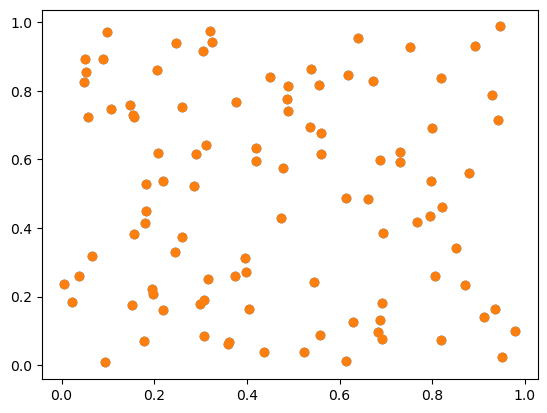

0.0
0.0


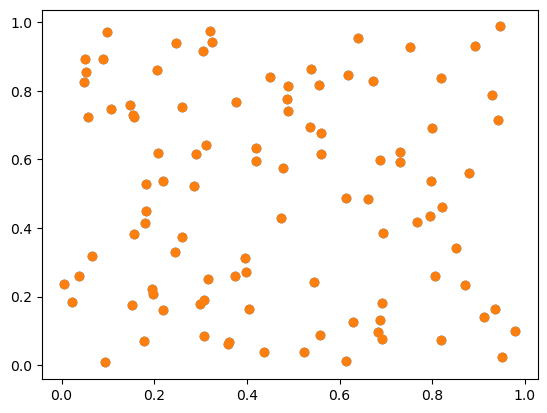

0.0
0.0


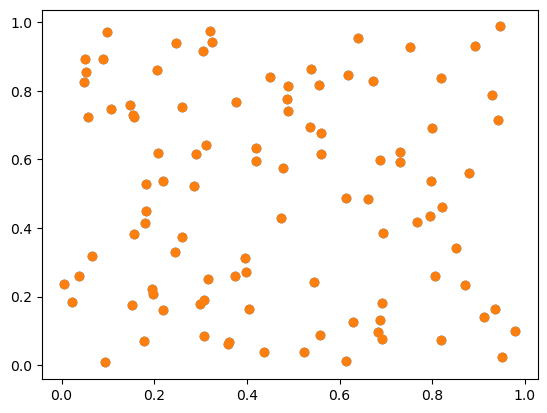

0.0
0.0


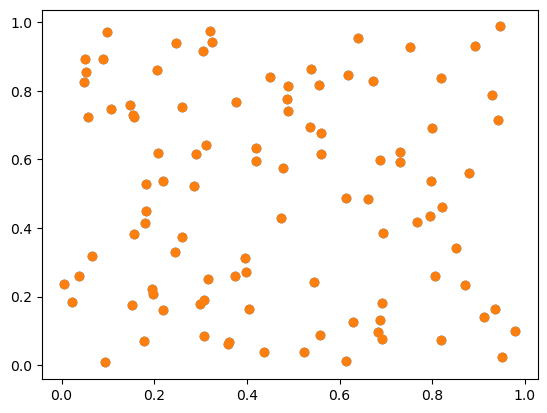

array([[-0.10163602, -0.99482165],
       [-0.99482165,  0.10163602],
       [-0.99497489,  0.10012475],
       [ 0.10012475,  0.99497489],
       [-0.05218778, -0.99863729],
       [-0.99863729,  0.05218778],
       [-0.22162219,  0.97513261],
       [ 0.97513261,  0.22162219],
       [-0.37101204,  0.92862806],
       [ 0.92862806,  0.37101204]])

In [390]:
# test the currectness of X_correspondence_sot
 # X point set should converge to Y point set. 
n,d=100,2
n_projections=10
X=np.random.rand(n,d)
Y=np.random.rand(n,d)
# projections=np.array([[-1],[1]],dtype=np.float64)
projections=random_projections(d,n_projections,1)
X_correspondence_sot(X,Y,projections)
projections

In [310]:
theta=np.array([-1])
X_theta,Y_theta=np.dot(theta,X.T),np.dot(theta,Y.T)
obj_theta=np.sum((X_theta-Y_theta)**2)
print(obj_theta)
gradient_theta=2*np.expand_dims(X_theta-Y_theta,1)*theta


0.19471513133858306


In [311]:
obj_theta

0.19471513133858306

In [237]:
X

array([[ 1.36152838e+08, -3.39736873e+07]])

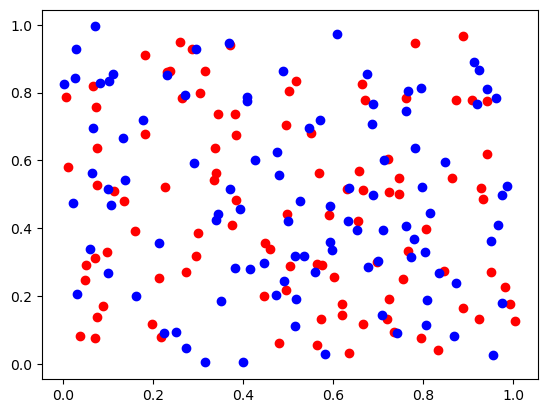

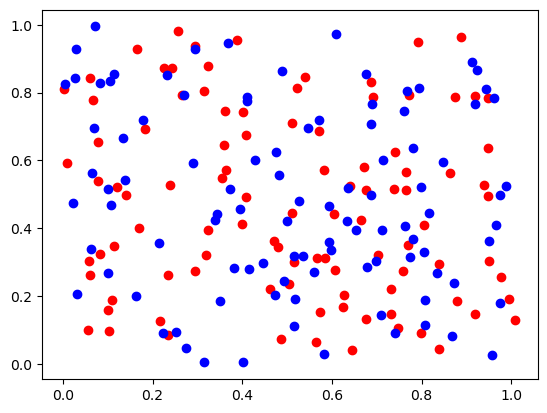

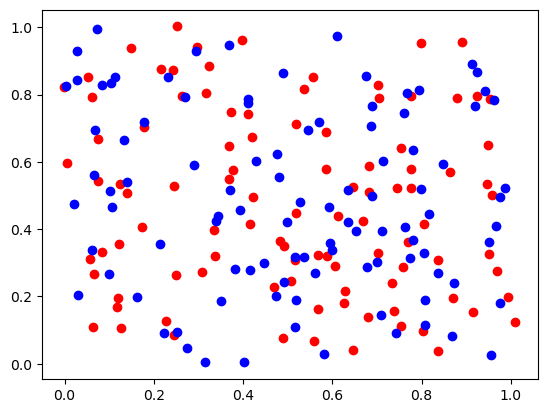

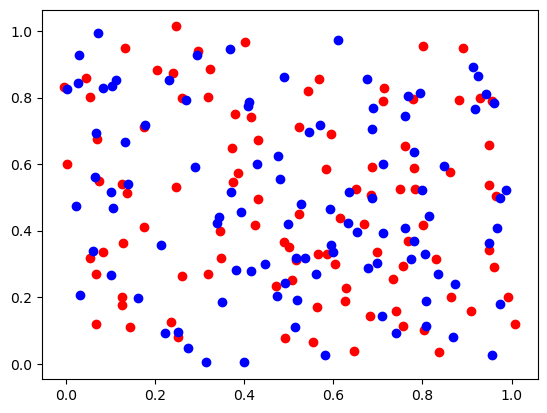

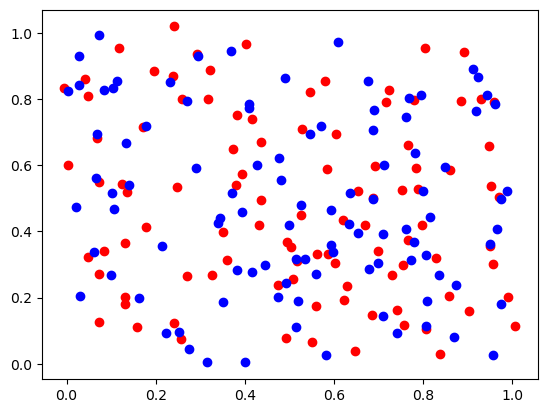

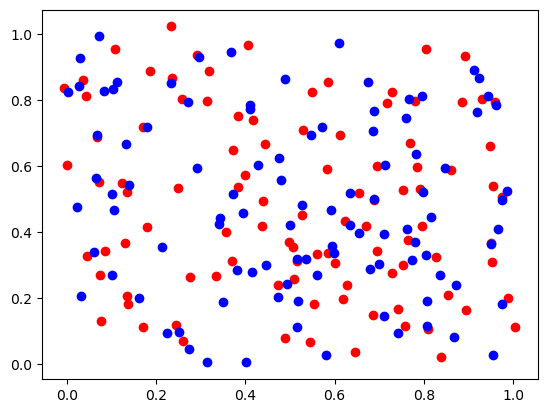

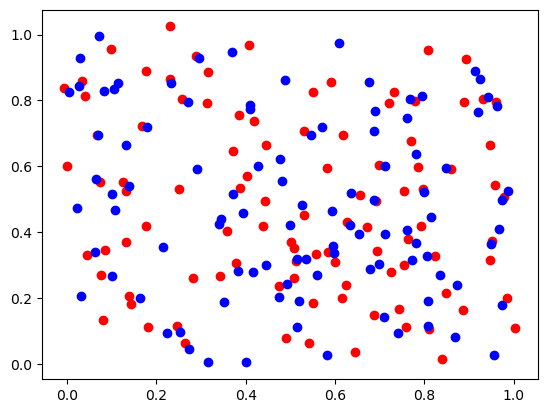

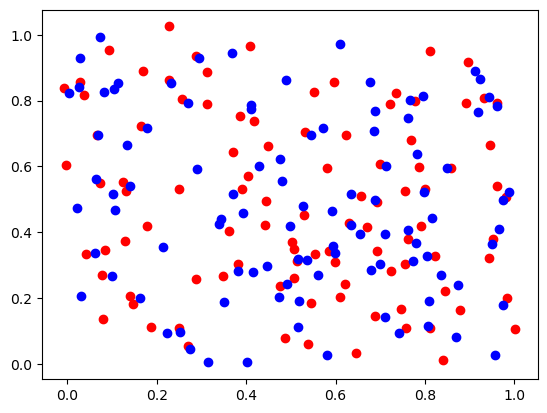

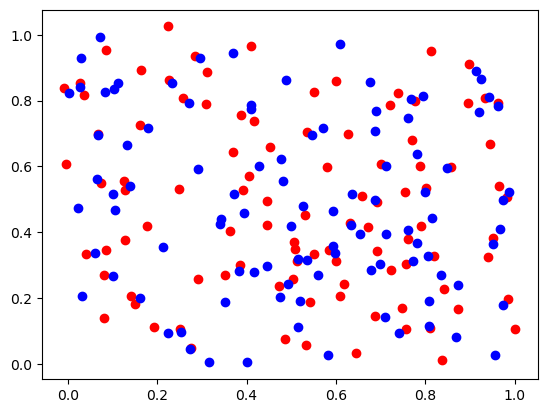

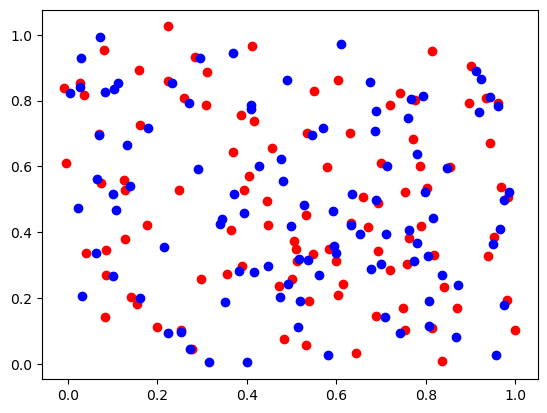

In [124]:
# However, if we increase n, we may not have convergence. 

n,d=100,2
X=np.random.rand(n,d)
Y=np.random.rand(n,d)
n_projections=30
projections=random_projections(d,n_projections)
result=X_correspondence_sot(X,Y,projections)

In [41]:
# But if we fix an correspondence, we always have fast convergence. 

def X_correspondence_fixed(X,Y,projections):
    N,d=projections.shape
    n=X.shape[0]
    L=np.arange(n)
    for i in range(N):
        theta=projections[i]
        X_theta,Y_theta=np.dot(theta,X.T),np.dot(theta,Y.T)
        Domain,Range=L>=0,L[L>=0]
        X_take,Y_take=X_theta[Domain],Y_theta[Range]
        X[Domain]+=np.expand_dims(Y_take-X_take,1)*theta
        plt.scatter(X[:,0],X[:,1],color='red') #.pyplot.scatter() 
        plt.scatter(Y[:,0],Y[:,1],color='blue')
        plt.xlim([-0.5,2])
        plt.ylim([-0.5,2])
        plt.show()
    return X

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

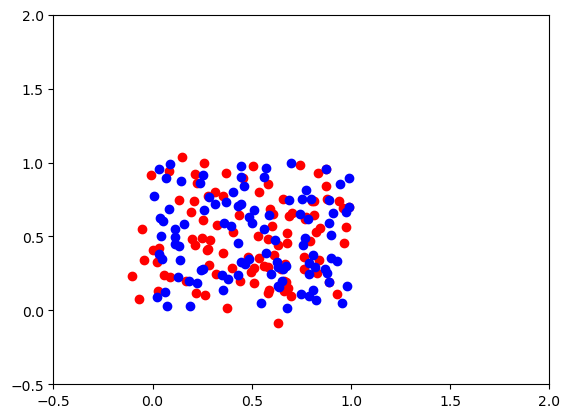

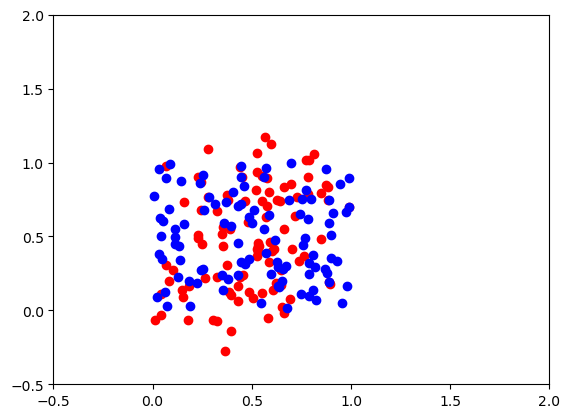

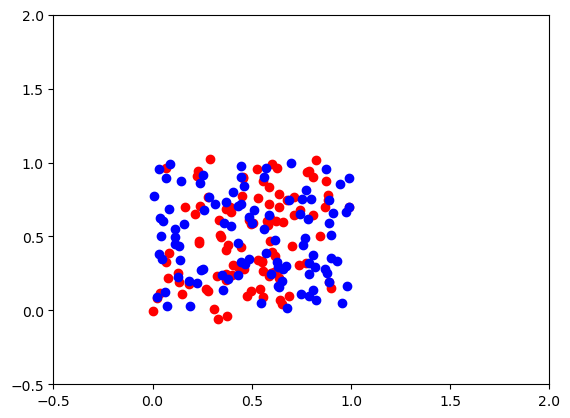

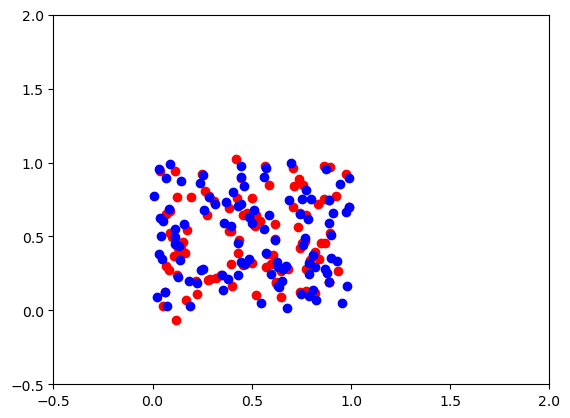

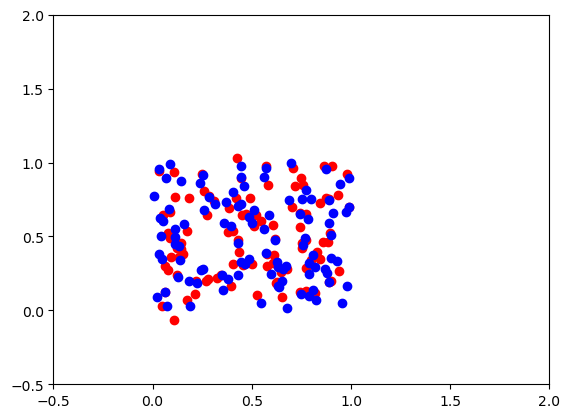

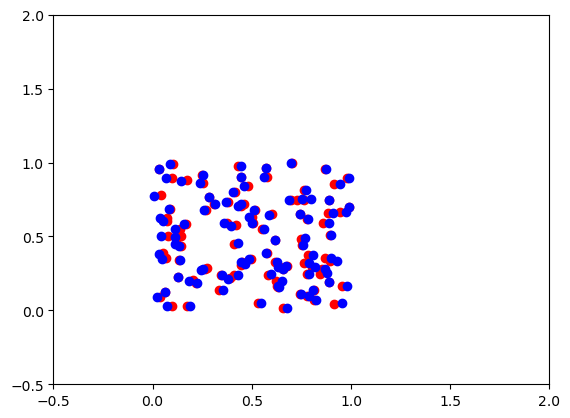

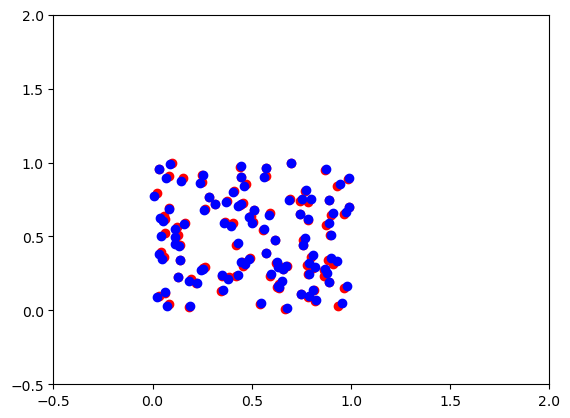

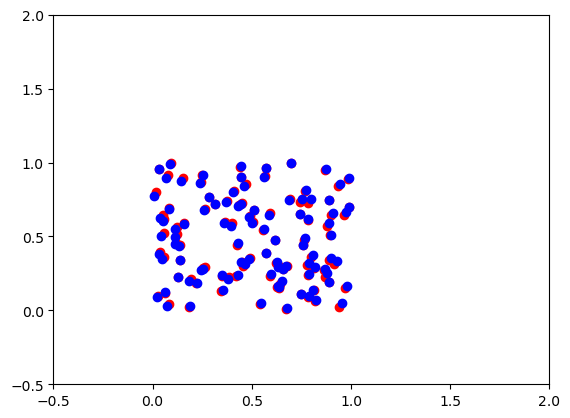

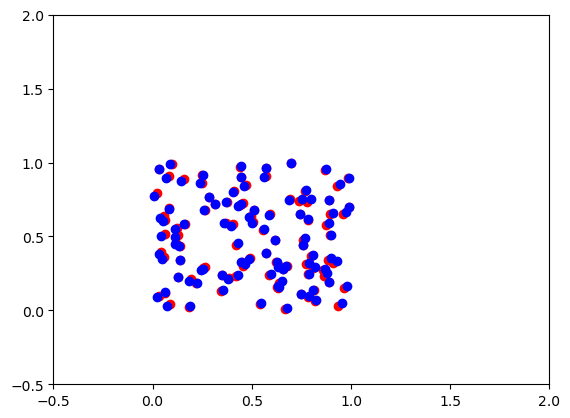

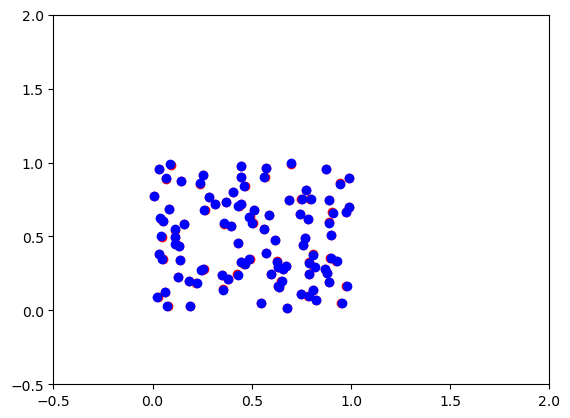

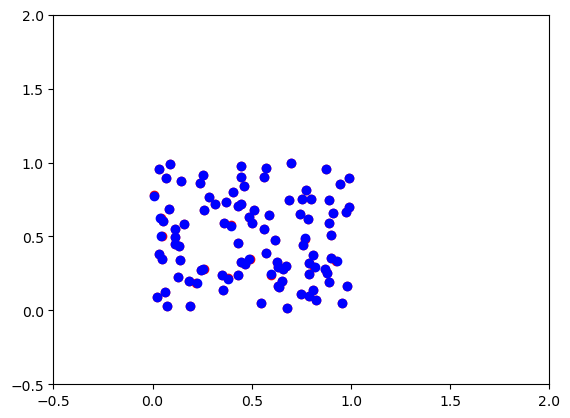

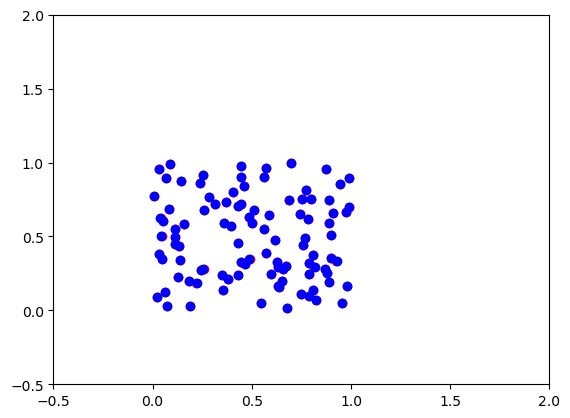

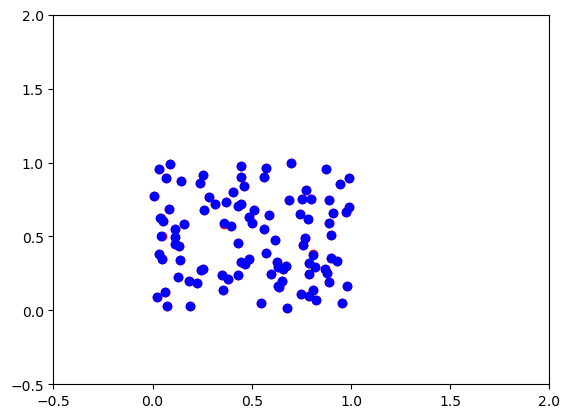

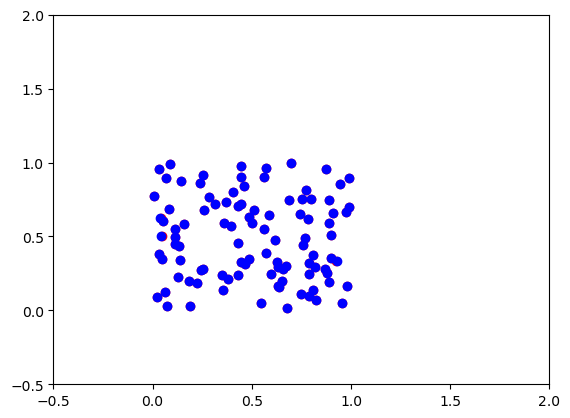

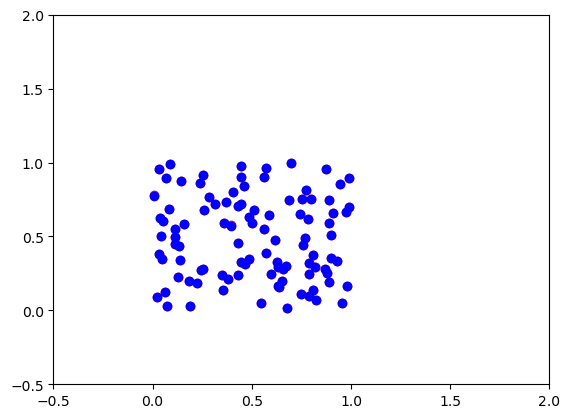

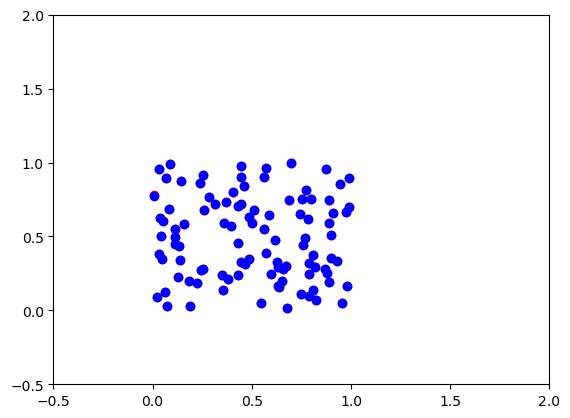

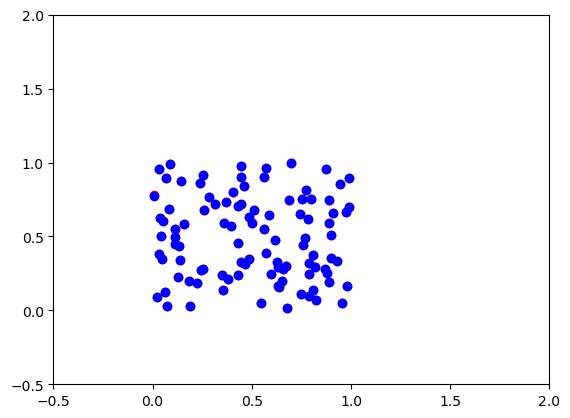

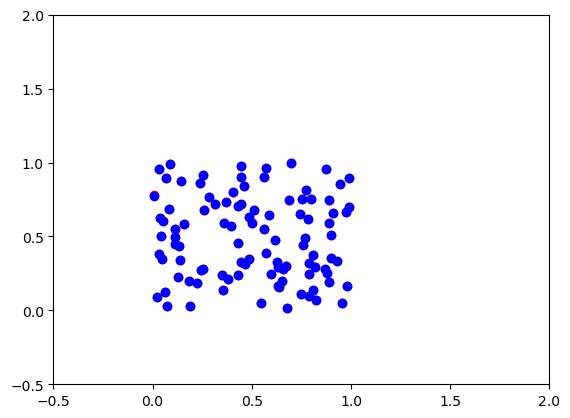

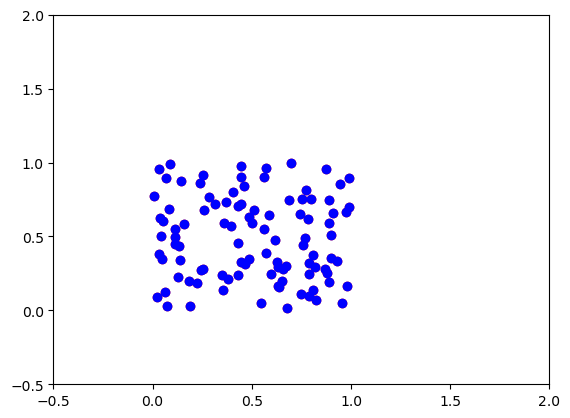

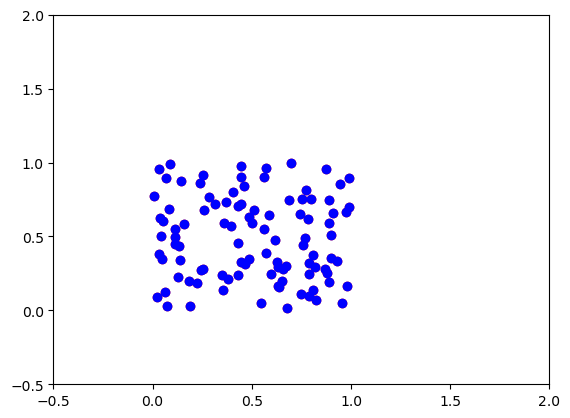

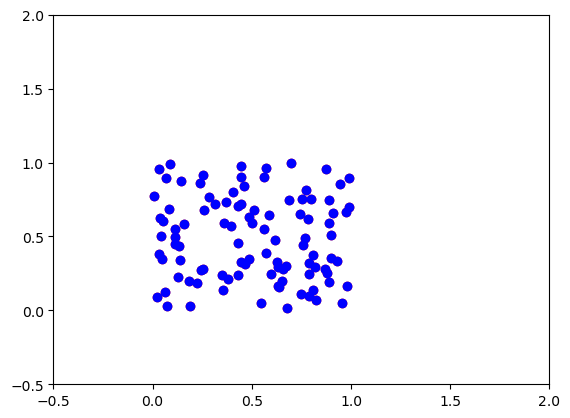

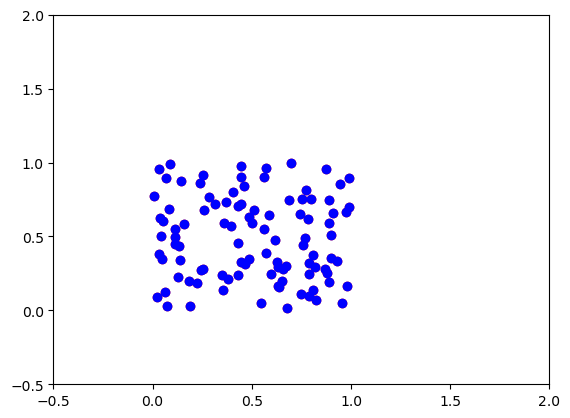

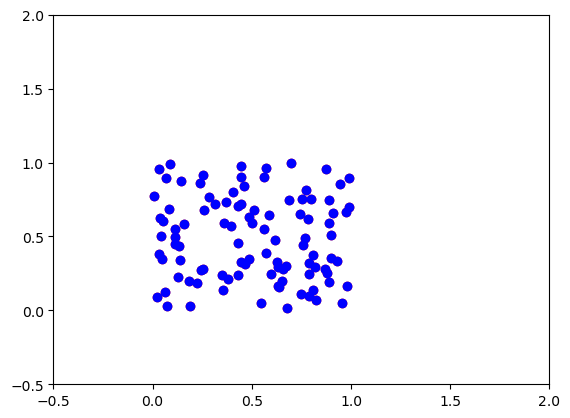

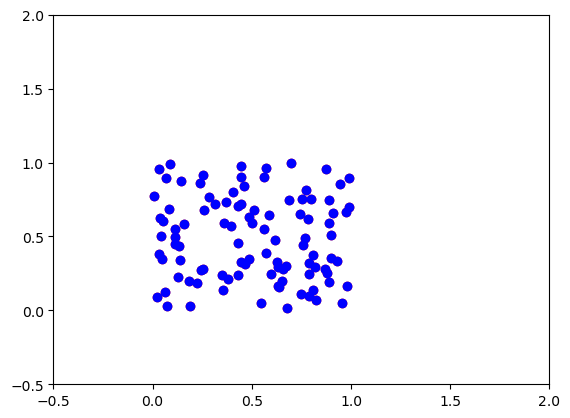

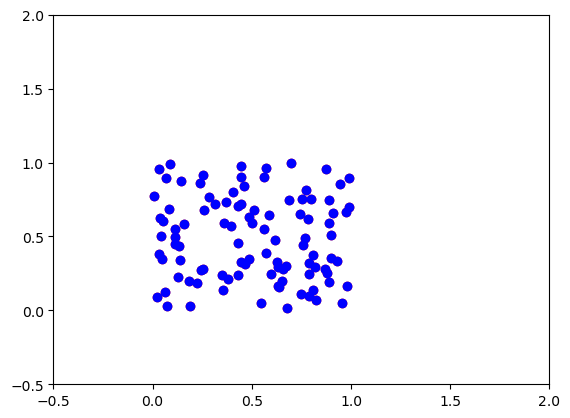

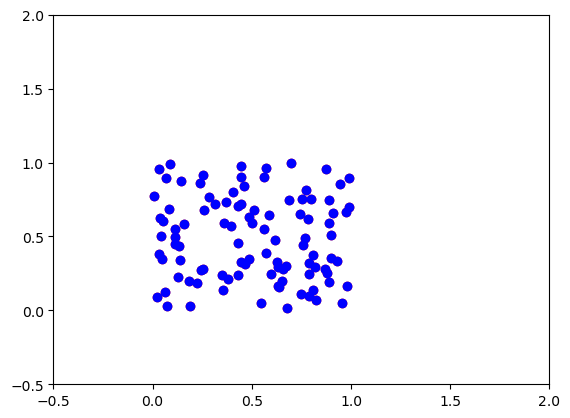

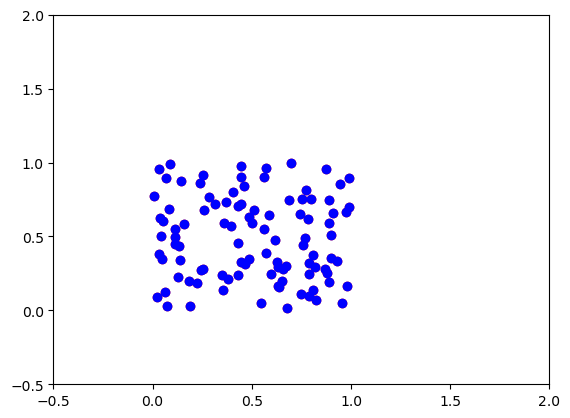

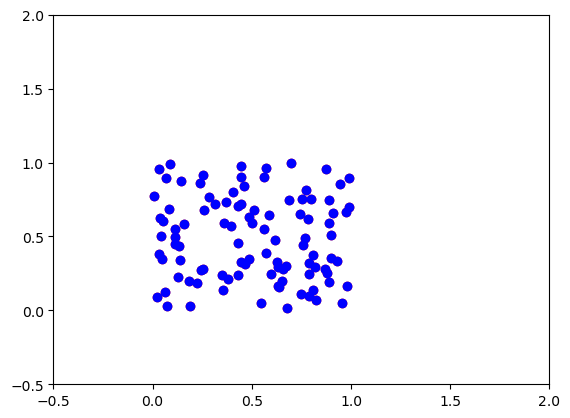

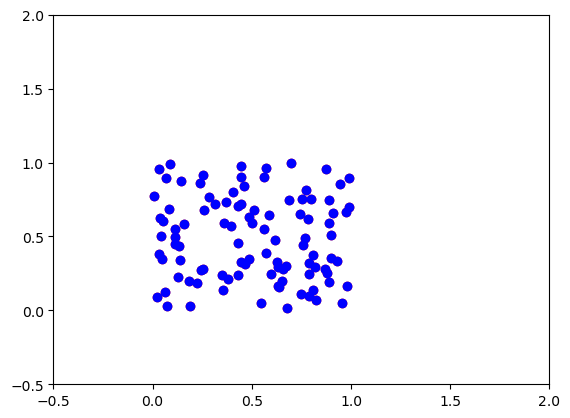

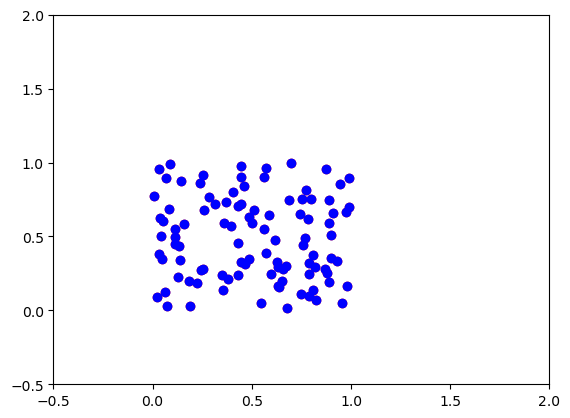

In [42]:
# However, if we increase n, we may not have convergence. 

n,d=100,2
X=np.random.rand(n,d)
Y=np.random.rand(n,d)
n_projections=30
projections=random_projections(d,n_projections)
result=X_correspondence_fixed(X,Y,projections)